# Laplacian Associative Memory (LAM) - DEV 01

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- Update gabor_conv
- FFT
- Crop instead of downsample
- Inject init conditiol directly as state rather than switching unit.

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch, PIL.Image, imageio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nn_torch import LAM
import libtools

---

#### DATA

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)

# img = libtools.downsample(img, 2) # Downsample
img = img[:100,:100] # Crop
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.02 max: 1.00


---

In [5]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [6]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 12


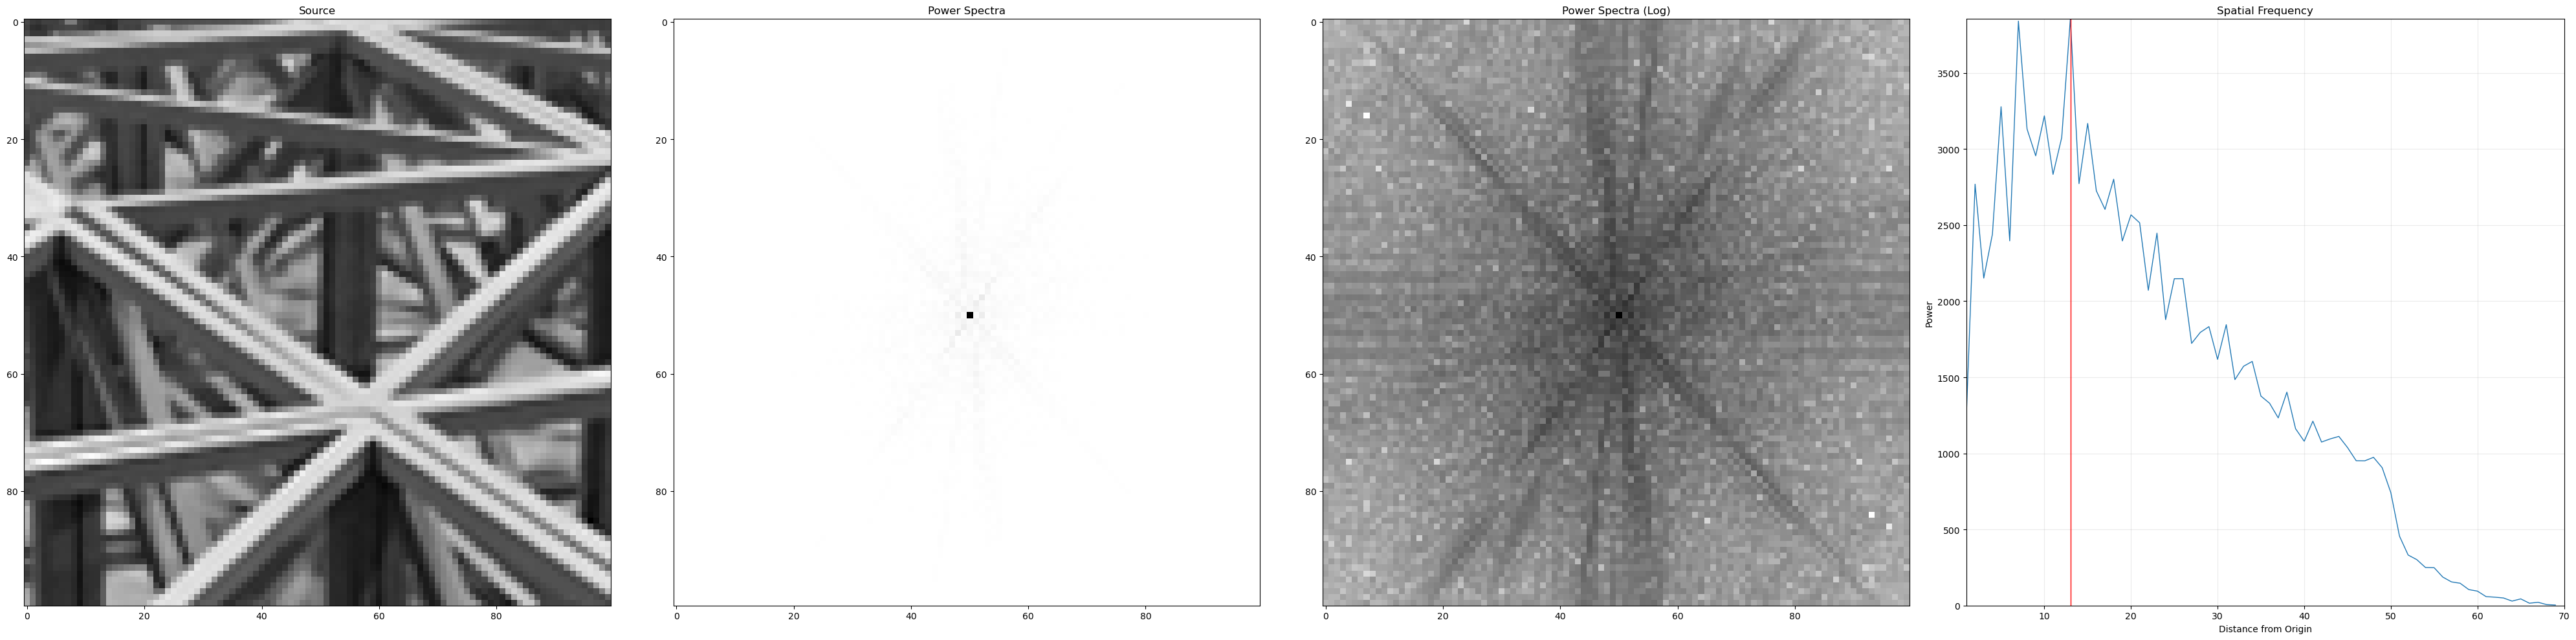

In [7]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

---

In [8]:
src = libtools.preference_map(16, count*2, img.shape[0]) # x2 power of spatial frequency FFT
# np.save('../data/mat/SOM_orient_v2.npy', src)
# src = np.load('../data/mat/SOM_orient_v2.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


In [9]:
features = libtools.gabor_conv(img, src, step=int(count)) # Power of spatial frequency FFT (No multiplicative factor)
features /= np.max(features)

print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


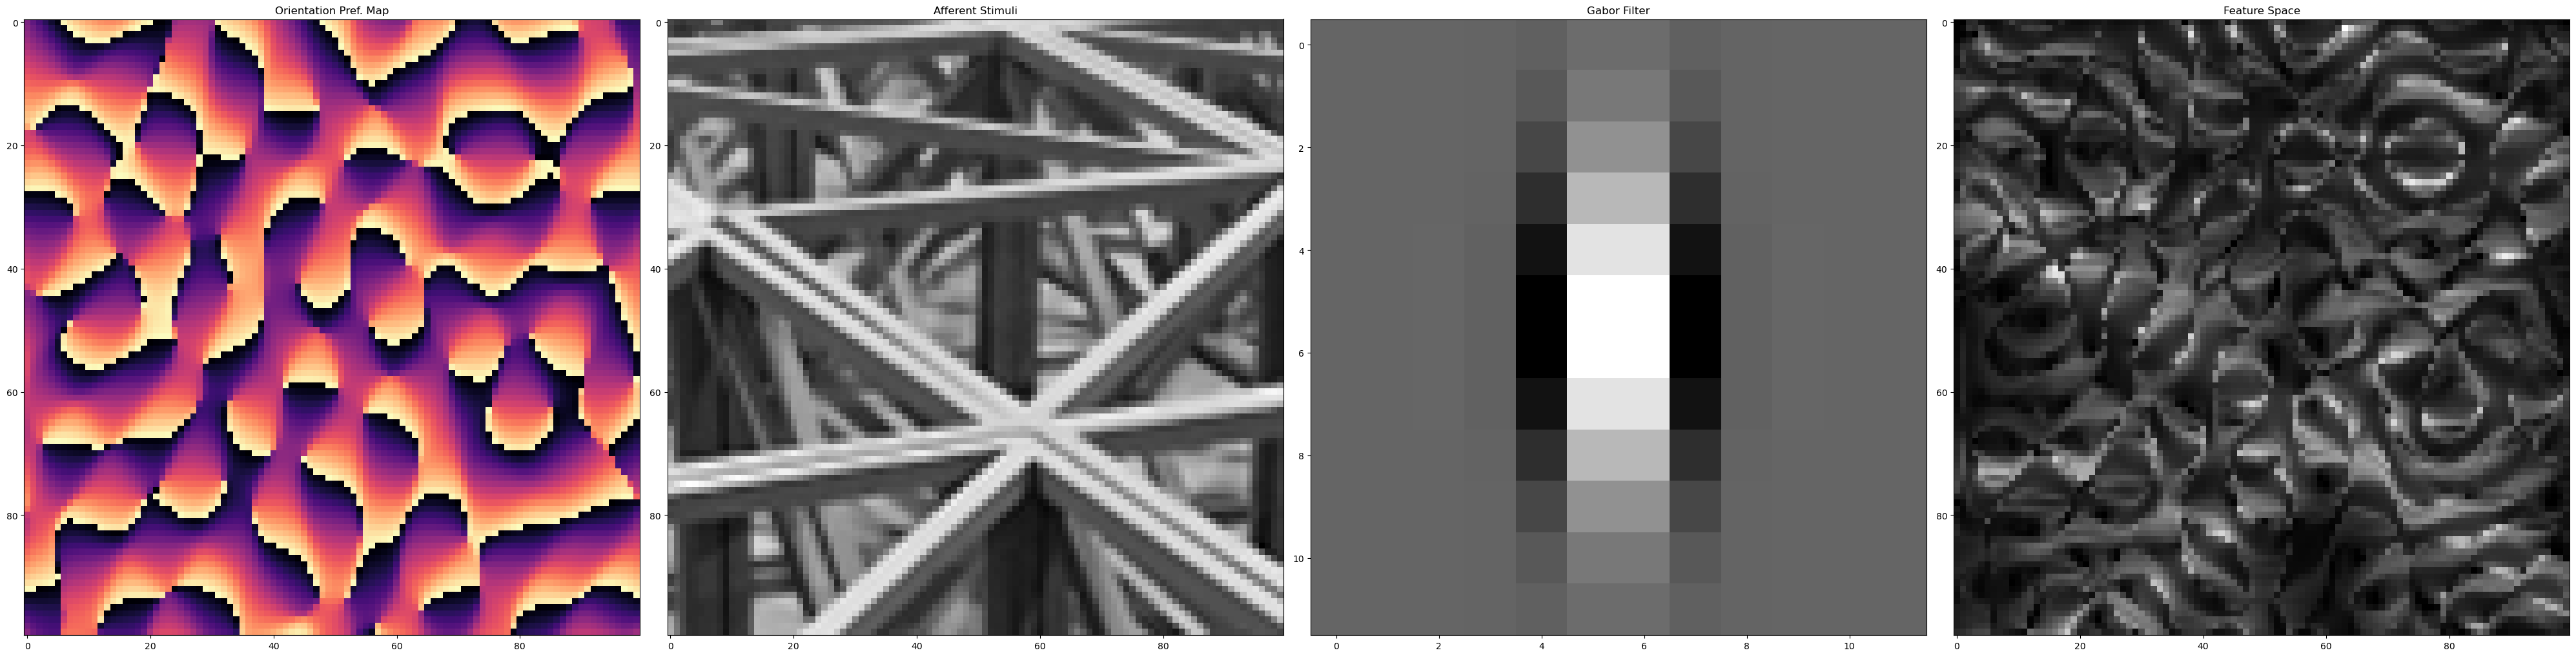

In [10]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,2,0, samples=int(count)), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

### HYPER-PARAMETERS

In [11]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-6                           # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE

In [12]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Correlation Matrix

In [13]:
# Convert to tensor
img = torch.from_numpy(img).float()
features = torch.from_numpy(features).float()
W = torch.from_numpy(W).float()

In [14]:
graph = LAM(N, P, prob, W, gamma, "asym") # Decompose Weights

In [15]:
activations = libtools.set_state(graph, features, 0.0825)
print("Sparsity:", np.sum(activations/np.size(activations)))

init_state = torch.from_numpy(activations).float()

Sparsity: 0.10369873046875


In [16]:
m_log, p_log, e_log = graph.simulate_single(alpha, eta, simlen, start_node, init_state.clone()) # Simulate

Using feature-based initial condition


100%|██████████| 3000/3000 [02:17<00:00, 21.86it/s]


In [17]:
m = m_log[-1,:].clone()
# m[start_node] = np.mean(np.delete(m, start_node))

Nactive = torch.mean(torch.sum((m > 0.5*m.max()).float(), dim=0))
print("Maximum overlap:", m.max())
print("Number of patterns:", Nactive)

Maximum overlap: tensor(0.0015)
Number of patterns: tensor(440.)


---

### PLOT

In [18]:
# HSV2RGB
m_norm = m + abs(m.min())
m_norm /= m_norm.max()

hsv_pattern = libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape))
hsv_features = libtools.grade(src/(2*np.pi), 1.0, features.reshape(src.shape))

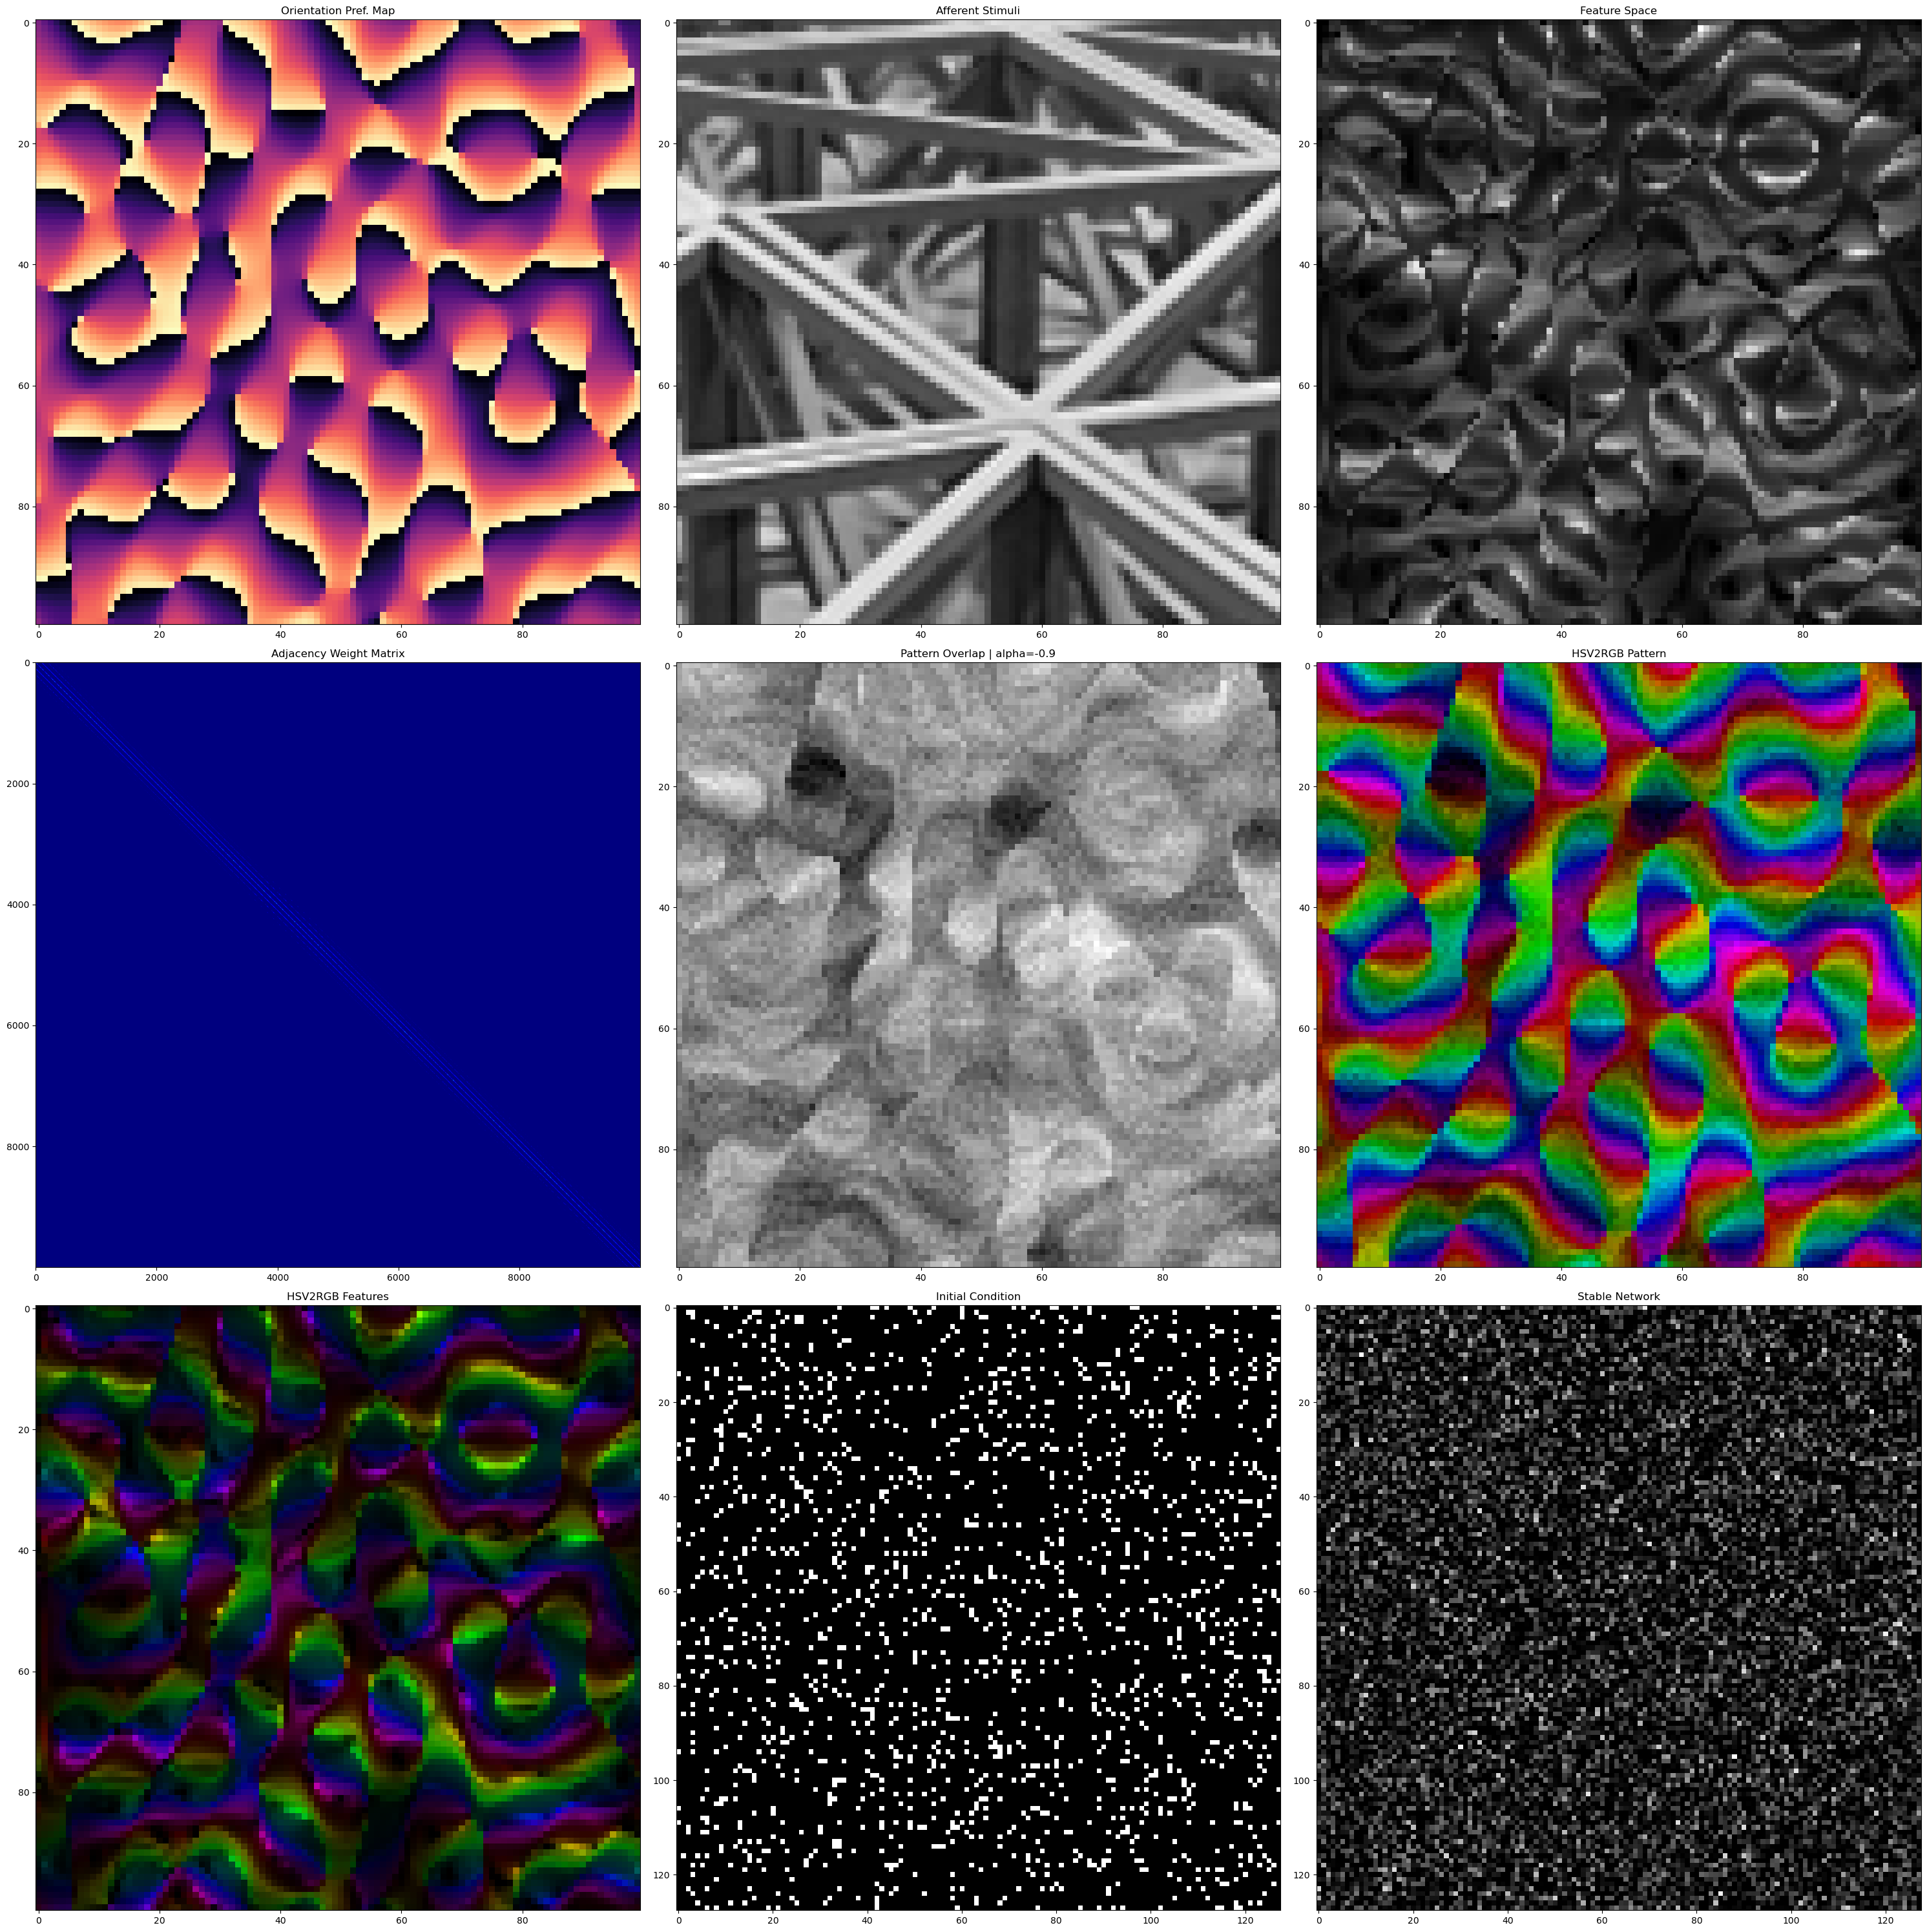

In [19]:
plt.figure(figsize=(30,30))
plt.subplot(3, 3, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(3, 3, 2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(3, 3, 3)
plt.imshow(features, 'gray')
plt.title('Feature Space')

plt.subplot(3, 3, 4)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(3, 3, 5)
plt.imshow(m.reshape(src.shape), 'gray')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(3, 3, 6)
plt.imshow(hsv_pattern)
plt.title("HSV2RGB Pattern")

plt.subplot(3, 3, 7)
plt.imshow(hsv_features)
plt.title("HSV2RGB Features")

plt.subplot(3, 3, 8)
dim = int(N**0.5)
plt.imshow(graph.xi[:, start_node].reshape([dim,dim]), 'gray')
plt.title("Initial Condition")

plt.subplot(3, 3, 9)
plt.imshow(graph.x.reshape([dim,dim]), 'gray')
plt.title("Stable Network")
plt.tight_layout()

---

### RENDER

In [20]:
libtools.render(m_log.reshape([simlen, src.shape[0], src.shape[1]]), 10, '../data/render/DEV/patternSim_DEV.gif', 'gray') # Pattern Overlap

RenderIO Complete


In [21]:
libtools.render(p_log.reshape([simlen, dim, dim]), 10, '../data/render/DEV/stateSim_DEV.gif', 'gray') # State Stabilisation

RenderIO Complete


In [22]:
hsv_log = []
for i in range(m_log.shape[0]):
    if i%10==0:
        m = m_log[i,:].clone()
        # m[start_node] = np.mean(np.delete(m, start_node))
        m_norm = m + abs(m.min())
        m_norm /= m_norm.max()

        hsv_log.append(libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape)))

hsv_log = np.array(hsv_log)

imageio.mimsave("../data/render/DEV/patternSim_hsv_DEV.gif", np.uint8(hsv_log * 255.0))